<a href="https://colab.research.google.com/github/Myavuzars/MachineLearning/blob/main/SMOTE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#SKLEARN
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/Machine Learning /Customer-Churn.csv")

df.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [6]:
df.drop(['customerID'], axis=1, inplace=True)

In [7]:
#Splitting data into Numerical and Categorical
catdf =df.iloc[:,:-3]
numdf= df.iloc[:,-3:-1]
y= df.iloc[:,-1]
numdf.head()

,MonthlyCharges,TotalCharges
0,29.85,29.85
1,56.95,1889.5
2,53.85,108.15
3,42.30,1840.75
4,70.70,151.65


In [8]:
#Converting data into Categorical
def convert_cat(df):
  for col in df.columns:
      df[col] = df[col].astype('category')

convert_cat(catdf)

In [9]:
#Removing missing variables
numdf['TotalCharges']=numdf['TotalCharges'].str.replace(' ','0').astype('float64')

In [10]:
#Encoding Categoricl Variables
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()

for col in catdf:
  catdf[col] = encoder.fit_transform(catdf[col])

In [11]:
#Encoding Target Variable
y= encoder.fit_transform(y)

In [12]:
#Scaling Numerical Variables
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
numdf =scaler.fit_transform(numdf)
numdf =pd.DataFrame(numdf)

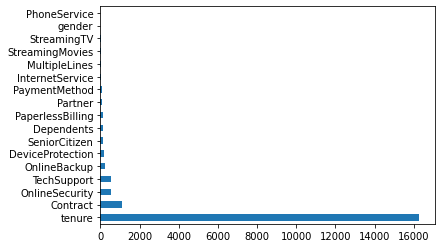

In [13]:
#Chi Square Independency Testing  
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
k=len(catdf.columns)
test = SelectKBest(score_func=chi2, k=k) 
fit = test.fit(catdf, y)
fit.scores_

imp = pd.Series(fit.scores_, index= catdf.columns)
imp.nlargest(k).plot(kind="barh")
plt.show()

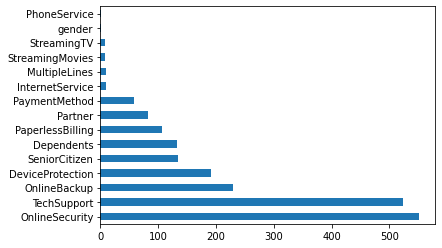

In [14]:
#Chi Square Independency Testing after removing tenure and Contract to see the better picture
cat_df =catdf.drop(['tenure', 'Contract'], axis=1)

k=len(cat_df.columns)
test = SelectKBest(score_func=chi2, k=k) 
fit = test.fit(cat_df, y)
fit.scores_

imp = pd.Series(fit.scores_, index= cat_df.columns)
imp.nlargest(k).plot(kind="barh")
plt.show()

In [15]:
# It is better drop the columns that scores lower than Payment Method 
new_catdf = catdf.drop(['PhoneService', 'gender', 'StreamingTV', 'MultipleLines','InternetService'], axis=1)
new_catdf.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0,1,0,1,0,2,0,0,0,0,1,2
1,0,0,0,34,2,0,2,0,0,1,0,3
2,0,0,0,2,2,2,0,0,0,0,1,3
3,0,0,0,45,2,0,2,2,0,1,0,0
4,0,0,0,2,0,0,0,0,0,0,1,2


In [16]:
new_catdf.nunique()

SeniorCitizen        2
Partner              2
Dependents           2
tenure              73
OnlineSecurity       3
OnlineBackup         3
DeviceProtection     3
TechSupport          3
StreamingMovies      3
Contract             3
PaperlessBilling     2
PaymentMethod        4
dtype: int64

In [17]:
#One hot encoding for categorical variables
ndf = pd.get_dummies(new_catdf, columns=['SeniorCitizen', 'Partner','Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingMovies','Contract', 'PaperlessBilling','PaymentMethod'], drop_first = True)

ndf.head()

,tenure,SeniorCitizen_1,Partner_1,Dependents_1,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_1,OnlineBackup_2,DeviceProtection_1,DeviceProtection_2,TechSupport_1,TechSupport_2,StreamingMovies_1,StreamingMovies_2,Contract_1,Contract_2,PaperlessBilling_1,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
1,34,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,45,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [18]:
#Generating X Data set after Feature Reduction
X = pd.concat([ndf,numdf], axis=1 )
X.head()

,tenure,SeniorCitizen_1,Partner_1,Dependents_1,OnlineSecurity_1,OnlineSecurity_2,OnlineBackup_1,OnlineBackup_2,DeviceProtection_1,DeviceProtection_2,TechSupport_1,TechSupport_2,StreamingMovies_1,StreamingMovies_2,Contract_1,Contract_2,PaperlessBilling_1,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,0,1
0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,-1.160323,-0.992611
1,34,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,-0.259629,-0.172165
2,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,-0.362660,-0.958066
3,45,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,-0.746535,-0.193672
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.197365,-0.938874


In [19]:
col_names=[]
for col in ndf.columns:
  col_names.append(col)
print(col_names)

['tenure', 'SeniorCitizen_1', 'Partner_1', 'Dependents_1', 'OnlineSecurity_1', 'OnlineSecurity_2', 'OnlineBackup_1', 'OnlineBackup_2', 'DeviceProtection_1', 'DeviceProtection_2', 'TechSupport_1', 'TechSupport_2', 'StreamingMovies_1', 'StreamingMovies_2', 'Contract_1', 'Contract_2', 'PaperlessBilling_1', 'PaymentMethod_1', 'PaymentMethod_2', 'PaymentMethod_3']


In [20]:
#Data Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [21]:
#copy of data partitinos for SMOTE texchniques

In [38]:
X1_train =X_train.copy(); X1_test =X_test.copy(); y1_train =y_train.copy(); y1_test =y_test.copy()
X2_train =X_train.copy(); X2_test =X_test.copy(); y2_train =y_train.copy(); y2_test =y_test.copy() 
X3_train =X_train.copy(); X3_test =X_test.copy(); y3_train =y_train.copy(); y3_test =y_test.copy() 
X4_train =X_train.copy(); X4_test =X_test.copy(); y4_train =y_train.copy(); y4_test =y_test.copy() 
X5_train =X_train.copy(); X5_test =X_test.copy(); y5_train =y_train.copy(); y5_test =y_test.copy() 

In [22]:
#MODELS

In [23]:
#Dummy Classifieer
from sklearn.dummy import DummyClassifier

# define the model
model_Dummy = DummyClassifier(strategy='most_frequent')
model_Dummy.fit(X_train, y_train)
Dummy_pred= model_Dummy.predict(X_test)
Dummy_score= round(model_Dummy.score(X, y),3)
Dummy_recall=recall_score(y_test,Dummy_pred)
Dummy_prec=precision_score(y_test,Dummy_pred)
Dummy_ROC_AUC=roc_auc_score(y_test,Dummy_pred)
Dummy_F1= 0
print(f'Dummy Score: {Dummy_score}')

Dummy Score: 0.735


In [24]:
#Logistic Regression (LOG)
from sklearn.linear_model import LogisticRegression
model_LOG= LogisticRegression()
model_LOG.fit(X_train, y_train)
LOG_pred= model_LOG.predict(X_test)
LOG_score= round(model_LOG.score(X, y),3)
print(f'Accuracy Score: {LOG_score}')

LOG_recall=round(recall_score(y_test,LOG_pred),3)
print(f'Recall Score: {LOG_recall}')

LOG_prec=round(precision_score(y_test,LOG_pred),3)
print(f'Precision Score: {LOG_prec}')

LOG_ROC_AUC=round(roc_auc_score(y_test,LOG_pred),3)
print(f'ROC_AUC Score: {LOG_ROC_AUC}')

LOG_F1= round(2 /((1/LOG_recall)+(1/LOG_prec)),3)
print(f'Precision Score: {LOG_F1}')

Accuracy Score: 0.803
Recall Score: 0.567
Precision Score: 0.656
ROC_AUC Score: 0.73
Precision Score: 0.608


In [25]:
#Decision Tree (Tree)
from sklearn import tree
model_Tree= tree.DecisionTreeClassifier()
model_Tree.fit(X_train, y_train)
Tree_pred= model_Tree.predict(X_test)
Tree_score= round(model_Tree.score(X, y),3)
print(f'Accuracy Score: {Tree_score}')

Tree_recall=round(recall_score(y_test,Tree_pred),3)
print(f'Recall Score: {Tree_recall}')

Tree_prec=round(precision_score(y_test,Tree_pred),3)
print(f'Precision Score: {Tree_prec}')

Tree_ROC_AUC=round(roc_auc_score(y_test,Tree_pred),3)
print(f'ROC_AUC Score: {Tree_ROC_AUC}')

Tree_F1= round(2 /((1/Tree_recall)+(1/Tree_prec)),3)
print(f'F1 Score: {Tree_F1}')

Accuracy Score: 0.928
Recall Score: 0.465
Precision Score: 0.476
ROC_AUC Score: 0.64
F1 Score: 0.47


In [26]:
#Support Vector Machine (SVM)
from sklearn import svm
from sklearn.svm import SVC
model_SVM= SVC(gamma='scale')

model_SVM.fit(X_train, y_train)
SVM_pred= model_SVM.predict(X_test)
SVM_score= round(model_SVM.score(X, y),3)
print(f'Accuracy Score: {SVM_score}')

SVM_recall=round(recall_score(y_test,SVM_pred),3)
print(f'Recall Score: {SVM_recall}')

SVM_prec=round(precision_score(y_test,SVM_pred),3)
print(f'Precision Score: {SVM_prec}')

SVM_ROC_AUC=round(roc_auc_score(y_test,SVM_pred),3)
print(f'ROC_AUC Score: {SVM_ROC_AUC}')

SVM_F1= round(2 /((1/SVM_recall)+(1/SVM_prec)),3)
print(f'Precision Score: {SVM_F1}')


Accuracy Score: 0.79
Recall Score: 0.42
Precision Score: 0.66
ROC_AUC Score: 0.671
Precision Score: 0.513


In [27]:
#Bagged Decision Trees (BAG)
from sklearn.ensemble import BaggingClassifier
model_BAG =BaggingClassifier(n_estimators=100)

model_BAG.fit(X_train, y_train)
BAG_pred= model_BAG.predict(X_test)
BAG_score= round(model_BAG.score(X, y),3)
print(f'Accuracy Score: {BAG_score}')

BAG_recall=round(recall_score(y_test,BAG_pred),3)
print(f'Recall Score: {BAG_recall}')

BAG_prec=round(precision_score(y_test,BAG_pred),3)
print(f'Precision Score: {BAG_prec}')

BAG_ROC_AUC=round(roc_auc_score(y_test,BAG_pred),3)
print(f'ROC_AUC Score: {BAG_ROC_AUC}')

BAG_F1= round(2 /((1/BAG_recall)+(1/BAG_prec)),3)
print(f'Precision Score: {BAG_F1}')

Accuracy Score: 0.945
Recall Score: 0.497
Precision Score: 0.632
ROC_AUC Score: 0.696
Precision Score: 0.556


In [28]:
#Random Forest (RF)
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier()

model_RF.fit(X_train, y_train)
RF_pred= model_RF.predict(X_test)
RF_score= round(model_RF.score(X, y),3)
print(f'Accuracy Score: {RF_score}')

RF_recall=round(recall_score(y_test,RF_pred),3)
print(f'Recall Score: {RF_recall}')

RF_prec=round(precision_score(y_test,RF_pred),3)
print(f'Precision Score: {RF_prec}')

RF_ROC_AUC=round(roc_auc_score(y_test,RF_pred),3)
print(f'ROC_AUC Score: {RF_ROC_AUC}')

RF_F1= round(2 /((1/RF_recall)+(1/RF_prec)),3)
print(f'Precision Score: {RF_F1}')

Accuracy Score: 0.944
Recall Score: 0.482
Precision Score: 0.622
ROC_AUC Score: 0.688
Precision Score: 0.543


In [29]:
#Gradient Boosting Machine (GBM)
from sklearn.ensemble import GradientBoostingClassifier
model_GB =GradientBoostingClassifier(n_estimators=100)

model_GB.fit(X_train, y_train)
GB_pred= model_GB.predict(X_test)
GB_score= round(model_GB.score(X, y),3)
print(f'Accuracy Score: {GB_score}')

GB_recall=round(recall_score(y_test,GB_pred),3)
print(f'Recall Score: {GB_recall}')

GB_prec=round(precision_score(y_test,GB_pred),3)
print(f'Precision Score: {GB_prec}')

GB_ROC_AUC=round(roc_auc_score(y_test,GB_pred),3)
print(f'ROC_AUC Score: {GB_ROC_AUC}')

GB_F1= round(2 /((1/GB_recall)+(1/GB_prec)),3)
print(f'Precision Score: {GB_F1}')


Accuracy Score: 0.819
Recall Score: 0.51
Precision Score: 0.67
ROC_AUC Score: 0.71
Precision Score: 0.579


In [30]:
#XGradient Boosting Machine (XGB)
from xgboost import XGBClassifier
model_XGB =XGBClassifier(n_estimators=100)

model_XGB.fit(X_train, y_train)
XGB_pred= model_XGB.predict(X_test)
XGB_score= round(model_XGB.score(X, y),3)
print(f'Accuracy Score: {XGB_score}')

XGB_recall=round(recall_score(y_test,XGB_pred),3)
print(f'Recall Score: {XGB_recall}')

XGB_prec=round(precision_score(y_test,XGB_pred),3)
print(f'Precision Score: {XGB_prec}')

XGB_ROC_AUC=round(roc_auc_score(y_test,XGB_pred),3)
print(f'ROC_AUC Score: {XGB_ROC_AUC}')

XGB_F1= round(2 /((1/XGB_recall)+(1/XGB_prec)),3)
print(f'Precision Score: {XGB_F1}')

Accuracy Score: 0.815
Recall Score: 0.51
Precision Score: 0.678
ROC_AUC Score: 0.711
Precision Score: 0.582


In [31]:
comparison1_df= pd.DataFrame({
    "Models" : ["Dummy", "Logistic Regression", "Decision tree", "SVM", "Random Forest", "Bagging", "Gradient Boosting", "Extreme Boosting"],
    "Accuracy Scores" :  [Dummy_score,    LOG_score,   Tree_score,   SVM_score,   BAG_score,   RF_score,   GB_score,   XGB_score],
    "Recall Scores"   :  [Dummy_recall,   LOG_recall,  Tree_recall,  SVM_recall,  BAG_recall,  RF_recall,  GB_recall,  XGB_recall],
    "Precision Scores" : [Dummy_prec,     LOG_prec,    Tree_prec,    SVM_prec,    BAG_prec,    RF_prec,    GB_prec,    XGB_prec],
    "ROC_AUC Scores" :   [Dummy_ROC_AUC,  LOG_ROC_AUC, Tree_ROC_AUC, SVM_ROC_AUC, BAG_ROC_AUC, RF_ROC_AUC, GB_ROC_AUC, XGB_ROC_AUC],
    "F1 Scores" :        [Dummy_F1,       LOG_F1,      Tree_F1,      SVM_F1,      BAG_F1,      RF_F1,      GB_F1,      XGB_F1]
})
comparison1_df= comparison1_df.sort_values(["Accuracy Scores"], ascending=True)

comparison1_df

,Models,Accuracy Scores,Recall Scores,Precision Scores,ROC_AUC Scores,F1 Scores
0,Dummy,0.735,0.000,0.000,0.500,0.000
3,SVM,0.790,0.420,0.660,0.671,0.513
1,Logistic Regression,0.803,0.567,0.656,0.730,0.608
7,Extreme Boosting,0.815,0.510,0.678,0.711,0.582
6,Gradient Boosting,0.819,0.510,0.670,0.710,0.579
2,Decision tree,0.928,0.465,0.476,0.640,0.470
5,Bagging,0.944,0.482,0.622,0.688,0.543
4,Random Forest,0.945,0.497,0.632,0.696,0.556


In [34]:
#SMOTE library
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import TomekLinks

In [35]:
#SMOTE Techniques
#1. SMOTE
over1 = SMOTE()
under = RandomUnderSampler()


#2. SVMSMOTE
over2 = SVMSMOTE()
under = RandomUnderSampler()


#3. KMeansSMOTE
over3 = KMeansSMOTE()
under = RandomUnderSampler()


#4. BorderlineSMOTE
over4 = BorderlineSMOTE()
under = RandomUnderSampler()
 

#5. SMOTENC (SMOTE for Nominal and Categorical variables)
over5 = SMOTENC(col_names)
under = RandomUnderSampler()


#6. SMOTE with Tomek Links 
resample=TomekLinks(sampling_strategy='majority')


In [36]:
# Define models 
# 1. SVM
model = LinearSVC(max_iter=10_000, random_state=10)

# define steps
steps1 = [('o', over1), ('u', under), ('m', model)]
steps2 = [('o', over2), ('u', under), ('m', model)]
steps3 = [('o', over3), ('u', under), ('m', model)]
steps4 = [('o', over4), ('u', under), ('m', model)]
steps5 = [('o', over5), ('u', under), ('m', model)]
steps6 = [('r', resample), ('m', model)]

#Pipelines
pipeline1 = Pipeline(steps=steps1)
pipeline2 = Pipeline(steps=steps2)
pipeline3 = Pipeline(steps=steps3)
pipeline4 = Pipeline(steps=steps4)
pipeline5 = Pipeline(steps=steps5)
pipeline6 = Pipeline(steps=steps6)


In [39]:
# Fit model 1
fit1=pipeline1.fit(X1_train, y1_train)
SMOTE_pred1= fit1.predict(X1_test)

#Accuracy Score
Score1= round(fit1.score(X1_test, y1_test),3)
print(f'Smote_Score: {Score1}')

#Recall Score
SMOTE1_recall=round(recall_score(y1_test,SMOTE_pred1),3)
print(f'SMOTE2_recall: {SMOTE1_recall}')

#Precision Score
SMOTE1_prec=round(precision_score(y1_test,SMOTE_pred1),3)
print(f'SMOTE2_precision: {SMOTE1_prec}')

#ROC_AUC Score
SMOTE1_ROC_AUC=round(roc_auc_score(y1_test,SMOTE_pred1),3)
print(f'SMOTE_roc_auc: {SMOTE1_ROC_AUC}')

#F1 Score
SMOTE1_F1=round(2 /((1/SMOTE1_recall)+(1/SMOTE1_prec)),3)
print(f'SMOTE_F1: {SMOTE1_F1}')

Smote_Score: 0.764
SMOTE2_recall: 0.694
SMOTE2_precision: 0.544
SMOTE_roc_auc: 0.742
SMOTE_F1: 0.61


In [40]:
# Fit model 2
fit2=pipeline2.fit(X2_train, y2_train)
SMOTE_pred2= fit2.predict(X2_test)

#Accuracy Score
Score2= round(fit2.score(X2_test, y2_test),3)
print(f'Smote2_Score: {Score2}')

#Recall Score
SMOTE2_recall=round(recall_score(y2_test,SMOTE_pred2),3)
print(f'SMOTE2_recall: {SMOTE2_recall}')

#Precision Score
SMOTE2_prec=round(precision_score(y2_test,SMOTE_pred2),3)
print(f'SMOTE2_precision: {SMOTE2_prec}')

#ROC_AUC Score
SMOTE2_ROC_AUC=round(roc_auc_score(y2_test,SMOTE_pred2),3)
print(f'SMOTE2_roc_auc: {SMOTE2_ROC_AUC}')

#F1 Score
SMOTE2_F1=round(2 /((1/SMOTE2_recall)+(1/SMOTE2_prec)),3)
print(f'SMOTE2_F1: {SMOTE2_F1}')

Smote2_Score: 0.718
SMOTE2_recall: 0.805
SMOTE2_precision: 0.481
SMOTE2_roc_auc: 0.746
SMOTE2_F1: 0.602


In [41]:
# Fit model 3
fit3=pipeline3.fit(X3_train, y3_train)
SMOTE_pred3= fit1.predict(X3_test)

#Accuracy Score
Score3= round(fit3.score(X3_test, y3_test),3)
print(f'Smote3_Score: {Score3}')

#Recall Score
SMOTE3_recall=round(recall_score(y3_test,SMOTE_pred3),3)
print(f'SMOTE3_recall: {SMOTE3_recall}')

#Precision Score
SMOTE3_prec=round(precision_score(y3_test,SMOTE_pred3),3)
print(f'SMOTE3_precision: {SMOTE3_prec}')

#ROC_AUC Score
SMOTE3_ROC_AUC=round(roc_auc_score(y3_test,SMOTE_pred3),3)
print(f'SMOTE3_roc_auc: {SMOTE3_ROC_AUC}')

#F1 Score
SMOTE3_F1=round(2 /((1/SMOTE3_recall)+(1/SMOTE3_prec)),3)
print(f'SMOTE3_F1: {SMOTE3_F1}')

Smote3_Score: 0.761
SMOTE3_recall: 0.747
SMOTE3_precision: 0.536
SMOTE3_roc_auc: 0.757
SMOTE3_F1: 0.624


In [42]:
# Fit model 4
fit4=pipeline1.fit(X4_train, y4_train)
SMOTE_pred4= fit4.predict(X4_test)

#Accuracy Score
Score4= round(fit4.score(X4_test, y4_test),3)
print(f'Smote4_Score: {Score4}')

#Recall Score
SMOTE4_recall=round(recall_score(y4_test,SMOTE_pred4),3)
print(f'SMOTE4_recall: {SMOTE4_recall}')

#Precision Score
SMOTE4_prec=round(precision_score(y4_test,SMOTE_pred4),3)
print(f'SMOTE4_precision: {SMOTE4_prec}')

#ROC_AUC Score
SMOTE4_ROC_AUC=round(roc_auc_score(y4_test,SMOTE_pred4),3)
print(f'SMOTE4_roc_auc: {SMOTE4_ROC_AUC}')

#F1 Score
SMOTE4_F1=round(2 /((1/SMOTE4_recall)+(1/SMOTE4_prec)),3)
print(f'SMOTE4_F1: {SMOTE4_F1}')

Smote4_Score: 0.759
SMOTE4_recall: 0.7
SMOTE4_precision: 0.535
SMOTE4_roc_auc: 0.74
SMOTE4_F1: 0.606


In [ ]:
# Fit model 5
fit5=pipeline5.fit(X5_train, y5_train)
SMOTE_pred5= fit5.predict(X5_test)

#Accuracy Score
Score5= round(fit5.score(X5_test, y5_test),3)
print(f'Smote_Score: {Score5}')

#Recall Score
SMOTE5_recall=round(recall_score(y5_test,SMOTE_pred5),3)
print(f'SMOTE5_recall: {SMOTE5_recall}')

#Precision Score
SMOTE5_prec=round(precision_score(y5_test,SMOTE5_pred1),3)
print(f'SMOTE2_precision: {SMOTE5_prec}')

#ROC_AUC Score
SMOTE5_ROC_AUC=round(roc_auc_score(y5_test,SMOTE5_pred1),3)
print(f'SMOTE_roc_auc: {SMOTE5_ROC_AUC}')

#F1 Score
SMOTE5_F1=round(2 /((1/SMOTE5_recall)+(1/SMOTE5_prec)),3)
print(f'SMOTE_F1: {SMOTE5_F1}')

In [45]:
# Fit model 6
fit6=pipeline6.fit(X2_train, y2_train)
SMOTE_pred6= fit6.predict(X2_test)

#Accuracy Score
Score6= round(fit6.score(X2_test, y2_test),3)
print(f'Smote6_Score: {Score6}')

#Recall Score
SMOTE6_recall=round(recall_score(y2_test,SMOTE_pred6),3)
print(f'SMOTE6_recall: {SMOTE6_recall}')

#Precision Score
SMOTE6_prec=round(precision_score(y2_test,SMOTE_pred6),3)
print(f'SMOTE6_precision: {SMOTE6_prec}')

#ROC_AUC Score
SMOTE6_ROC_AUC=round(roc_auc_score(y2_test,SMOTE_pred6),3)
print(f'SMOTE6_roc_auc: {SMOTE6_ROC_AUC}')

#F1 Score
SMOTE6_F1=round(2 /((1/SMOTE6_recall)+(1/SMOTE6_prec)),3)
print(f'SMOTE6_F1: {SMOTE6_F1}')

Smote6_Score: 0.794
SMOTE6_recall: 0.642
SMOTE6_precision: 0.606
SMOTE6_roc_auc: 0.746
SMOTE6_F1: 0.623


In [46]:
comparison2_df= pd.DataFrame({
    "Models" : [ "SVM", "Logistic Regression", "SMOTE", "SVMSMOTE",  "KMeansSMOTE", "BorderlineSMOTE", "SMOTE_TomekLinks"],
    "Accuracy Scores" :  [SVM_score,   LOG_score,    Score1,          Score2,         Score3,         Score4,           Score6 ],
    "Recall Scores"   :  [SVM_recall,  LOG_recall,   SMOTE1_recall,   SMOTE2_recall,  SMOTE3_recall,  SMOTE4_recall,    SMOTE6_recall],
    "Precision Scores" : [SVM_prec,    LOG_prec,     SMOTE1_prec,     SMOTE2_prec,    SMOTE3_prec,    SMOTE4_prec,      SMOTE6_prec],
    "ROC_AUC Scores" :   [SVM_ROC_AUC, LOG_ROC_AUC,  SMOTE1_ROC_AUC,  SMOTE2_ROC_AUC, SMOTE3_ROC_AUC, SMOTE4_ROC_AUC ,  SMOTE6_ROC_AUC],
    "F1 Scores" :        [SVM_F1,      LOG_F1,       SMOTE1_F1,       SMOTE2_F1,      SMOTE3_F1,      SMOTE4_F1,        SMOTE6_F1]
})
comparison2_df= comparison2_df.sort_values(["F1 Scores"], ascending=True)

comparison2_df

,Models,Accuracy Scores,Recall Scores,Precision Scores,ROC_AUC Scores,F1 Scores
0,SVM,0.790,0.420,0.660,0.671,0.513
3,SVMSMOTE,0.718,0.805,0.481,0.746,0.602
5,BorderlineSMOTE,0.759,0.700,0.535,0.740,0.606
1,Logistic Regression,0.803,0.567,0.656,0.730,0.608
2,SMOTE,0.764,0.694,0.544,0.742,0.610
6,SMOTE_TomekLinks,0.794,0.642,0.606,0.746,0.623
4,KMeansSMOTE,0.761,0.747,0.536,0.757,0.624


In [47]:
#COST SENSITIVE APPROACH

In [48]:
#####
#Weighted Logistic Regression

In [49]:
#Simple Logistic Regression
model_LG1 = LogisticRegression(random_state=1, class_weight=None)
model_LG1.fit(X_train, y_train)
LG1_pred = model_LG1.predict(X_test)

print(f'Confusion Matrix:\n {confusion_matrix(y_test, LG1_pred)}')
print()

LG1_score= round(model_LG1.score(X_test, y_test),3)
print(f'Accuracy Score: {LG1_score}')

LG1_recall=round(recall_score(y_test,LG1_pred),3)
print(f'Recall Score: {LG1_recall}')

LG1_prec=round(precision_score(y_test,LG1_pred),3)
print(f'Precision Score: {LG1_prec}')

LG1_ROC_AUC=round(roc_auc_score(y_test,LG1_pred),3)
print(f'ROC_AUC Score: {LG1_ROC_AUC}')

LG1_F1= round(2 /((1/LG1_recall)+(1/LG1_prec)),3)
print(f'Precision Score: {LG1_F1}')

Confusion Matrix:
 [[1155  139]
 [ 202  265]]

Accuracy Score: 0.806
Recall Score: 0.567
Precision Score: 0.656
ROC_AUC Score: 0.73
Precision Score: 0.608


In [50]:
#Balanced Logistic Regression
model_LG2 = LogisticRegression(random_state=1, class_weight='balanced')
model_LG2.fit(X_train, y_train)
LG2_pred = model_LG2.predict(X_test)

print(f'Confusion Matrix:\n {confusion_matrix(y_test, LG2_pred)}')
print()

LG2_score= round(model_LG2.score(X_test, y_test),3)
print(f'Accuracy Score: {LG2_score}')

LG2_recall=round(recall_score(y_test,LG2_pred),3)
print(f'Recall Score: {LG2_recall}')

LG2_prec=round(precision_score(y_test,LG2_pred),3)
print(f'Precision Score: {LG2_prec}')

LG2_ROC_AUC=round(roc_auc_score(y_test,LG2_pred),3)
print(f'ROC_AUC Score: {LG2_ROC_AUC}')

LG2_F1= round(2 /((1/LG2_recall)+(1/LG2_prec)),3)
print(f'Precision Score: {LG2_F1}')

Confusion Matrix:
 [[923 371]
 [101 366]]

Accuracy Score: 0.732
Recall Score: 0.784
Precision Score: 0.497
ROC_AUC Score: 0.749
Precision Score: 0.608


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Text(0.5, 1.0, 'Scoring for different class weights')

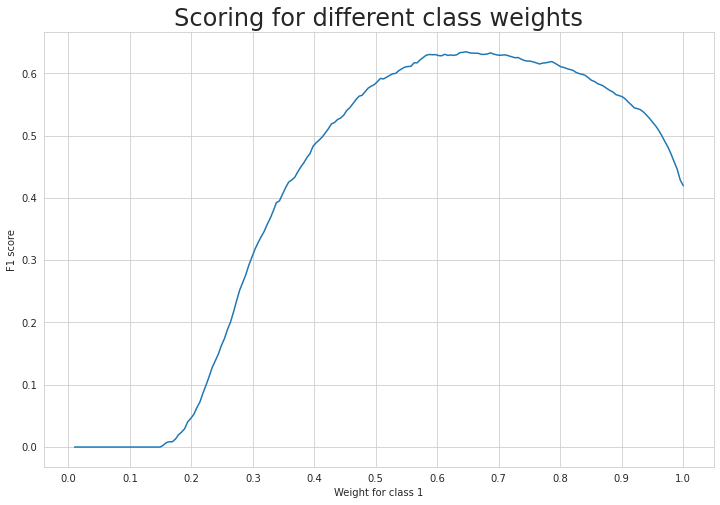

In [51]:
#Weighted Logistic Regression

#Choosing the weight
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [52]:
model_LG3 = LogisticRegression(solver='newton-cg', class_weight={0: 0.27, 1: 0.73})
model_LG3.fit(X_train, y_train)
LG3_pred = model_LG3.predict(X_test)

print(f'Confusion Matrix:\n {confusion_matrix(y_test, LG3_pred)}')

LG3_score= round(model_LG3.score(X_test, y_test),3)
print(f'Accuracy Score: {LG3_score}')

LG3_recall=round(recall_score(y_test,LG3_pred),3)
print(f'Recall Score: {LG3_recall}')

LG3_prec=round(precision_score(y_test,LG3_pred),3)
print(f'Precision Score: {LG3_prec}')

LG3_ROC_AUC=round(roc_auc_score(y_test,LG3_pred),3)
print(f'ROC_AUC Score: {LG3_ROC_AUC}')

LG3_F1= round(2 /((1/LG3_recall)+(1/LG3_prec)),3)
print(f'Precision Score: {LG3_F1}')

Confusion Matrix:
 [[931 363]
 [104 363]]

Recall Score: 0.7773019271948608
Accuracy Score: 0.735
Recall Score: 0.777
Precision Score: 0.5
ROC_AUC Score: 0.748
Precision Score: 0.608


In [53]:
#Weighted (Balanced) Support Vector Machine (SVM)
from sklearn import svm
from sklearn.svm import SVC
model_SVM1= SVC(kernel='linear',class_weight='balanced', C=1.0,  random_state=0)

model_SVM1.fit(X_train, y_train)
SVM1_pred= model_SVM1.predict(X_test)
SVM1_score= round(model_SVM1.score(X_test, y_test),3)
print(f'Accuracy Score: {SVM1_score}')

SVM1_recall=round(recall_score(y_test,SVM1_pred),3)
print(f'Recall Score: {SVM1_recall}')

SVM1_prec=round(precision_score(y_test,SVM1_pred),3)
print(f'Precision Score: {SVM1_prec}')

SVM1_ROC_AUC=round(roc_auc_score(y_test,SVM1_pred),3)
print(f'ROC_AUC Score: {SVM1_ROC_AUC}')

SVM1_F1= round(2 /((1/SVM1_recall)+(1/SVM1_prec)),3)
print(f'Precision Score: {SVM1_F1}')


Accuracy Score: 0.707
Recall Score: 0.831
Precision Score: 0.47
ROC_AUC Score: 0.747
Precision Score: 0.6


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Text(0.5, 1.0, 'Scoring for different class weights')

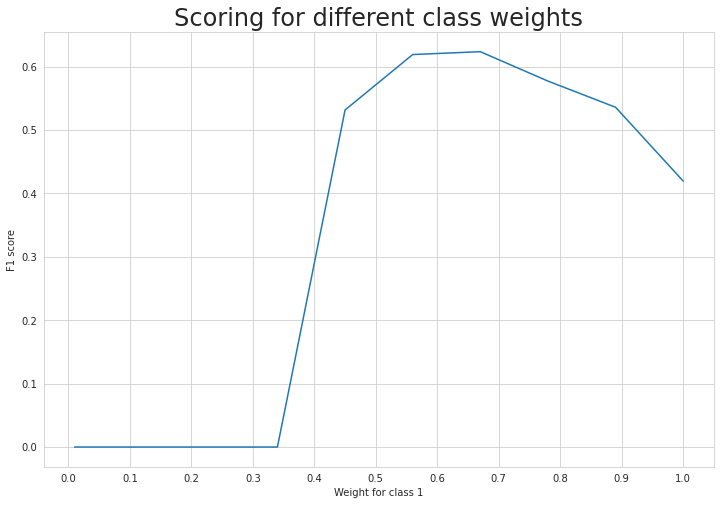

In [54]:
#Weighted Logistic Regression

#Choosing the weight
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = SVC(kernel='linear')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,10)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [55]:
#Weighted Support Vector Machine (SVM)
from sklearn import svm
from sklearn.svm import SVC
model_SVM2= SVC(kernel='linear',class_weight={0: 0.32, 1: 0.68}, C=1.0, random_state=0)

model_SVM2.fit(X_train, y_train)
SVM2_pred= model_SVM2.predict(X_test)
SVM2_score= round(model_SVM2.score(X_test, y_test),3)
print(f'Accuracy Score: {SVM2_score}')

SVM2_recall=round(recall_score(y_test,SVM2_pred),3)
print(f'Recall Score: {SVM2_recall}')

SVM2_prec=round(precision_score(y_test,SVM2_pred),3)
print(f'Precision Score: {SVM2_prec}')

SVM2_ROC_AUC=round(roc_auc_score(y_test,SVM2_pred),3)
print(f'ROC_AUC Score: {SVM2_ROC_AUC}')

SVM2_F1= round(2 /((1/SVM2_recall)+(1/SVM2_prec)),3)
print(f'Precision Score: {SVM2_F1}')

Accuracy Score: 0.741
Recall Score: 0.773
Precision Score: 0.508
ROC_AUC Score: 0.751
Precision Score: 0.613


In [56]:
comparison3_df= pd.DataFrame({
    "Models" :           [ "LG simple", "LG (Balanced)", "LG (Weighted)", "SVM simple", "SVM Balanced",  "SVM (Weighted)"],
    "Accuracy Scores" :  [LG1_score,   LG2_score,    LG3_score,          SVM_score,         SVM1_score,         SVM2_score],
    "Recall Scores"   :  [LG1_recall,  LG2_recall,   LG3_recall,      SVM_recall,   SVM1_recall,  SVM2_recall],
    "Precision Scores" : [LG1_prec,    LG2_prec,     LG3_prec,     SVM_prec,    SVM1_prec,    SVM2_prec],
    "ROC_AUC Scores" :   [LG1_ROC_AUC, LG2_ROC_AUC,  LG3_ROC_AUC,  SVM_ROC_AUC, SVM1_ROC_AUC, SVM1_ROC_AUC],
    "F1 Scores" :        [LG1_F1,      LG2_F1,       LG3_F1,       SVM_F1,      SVM1_F1,      SVM2_F1]
})
comparison3_df= comparison3_df.sort_values(["F1 Scores"], ascending=True)

comparison3_df

,Models,Accuracy Scores,Recall Scores,Precision Scores,ROC_AUC Scores,F1 Scores
3,SVM simple,0.790,0.420,0.660,0.671,0.513
4,SVM Balanced,0.707,0.831,0.470,0.747,0.600
0,LG simple,0.806,0.567,0.656,0.730,0.608
1,LG (Balanced),0.732,0.784,0.497,0.749,0.608
2,LG (Weighted),0.735,0.777,0.500,0.748,0.608
5,SVM (Weighted),0.741,0.773,0.508,0.747,0.613
